In [934]:
#Libraries Used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta

## Initial Exploration of Data

In [935]:
sneaker_data = pd.read_csv('Q1_DATA.csv')
sneaker_data.head(20)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11
5,6,58,882,138,1,credit_card,2017-03-14 15:25:01
6,7,87,915,149,1,cash,2017-03-01 21:37:57
7,8,22,761,292,2,cash,2017-03-08 2:05:38
8,9,64,914,266,2,debit,2017-03-17 20:56:50
9,10,52,788,146,1,credit_card,2017-03-30 21:08:26


In [936]:
total_rev = sneaker_data.order_amount.sum()
num_orders = sneaker_data.order_id.count()
AOV = total_rev / num_orders
print("Current AOV value {:.2f}".format(AOV))

Current AOV value 3145.13


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2e965da0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2e972470>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2e965978>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2e972b00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2e972e48>],
 'means': []}

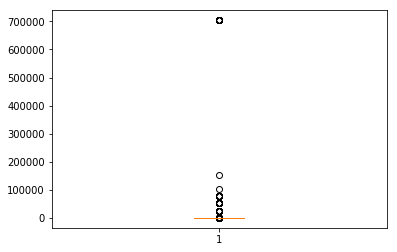

In [937]:
#Analyzing the distribution of order amount data
plt.boxplot(sneaker_data.order_amount)

{'whiskers': [<matplotlib.lines.Line2D at 0x1a2c7e1f28>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2c7ee5f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2c7e1b38>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2c7eec88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2c7eefd0>],
 'means': []}

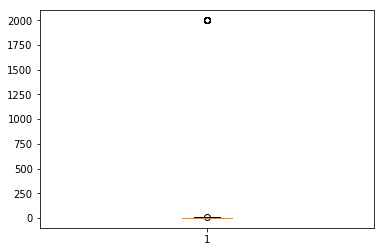

In [938]:
#Analyzing the distribution of the number of items ordered
plt.boxplot(sneaker_data.total_items)

## My Proposed Approach

__*Rationale behind my approach*__

1. *Issue with the current Average Order Value (AOV) definition*
    - After looking through the data the issue with the current AOV value is that it is inflated/skewed upwards as a 
    result of numerous wholesale transactions which are driving this upward pressure in the AOV number. I believe what this current AOV calculation fails to take into consideration is the key notion of "no one customer is the same". The calculation does not factor in the differences in user buying behaviour and ultimately the differences between different consumer segments - this leads to an AOV value that offers little insight into the ordering behaviour of users. 

2. *Proposed Approach*
    - I propose to use a weighted AOV that leverages a RFM (Recency, Frequency and Monetary) Model as my metric to report on this dataset. I decided to use a RFM model as a basis for my weighted AOV metric because I believe it's 3 components - Recency: how recent a customer made a purchase, Frequency: how often a customer makes purchase, Monetary: how much a customer spends on each purchase - best capture the uniqueness between customers based on their purchasing behaviour. The insights/outputs of this model can then be applied to transactional data as it will enables us to place more significance on certain purchases based on the importance of that particular customer/segment to the business. 
        
    The high level approach is to use the RFM model to segment the 301 users into distinct segments based on their unique buying behaviour. Weights will then be calculated based on the size of the segment in relation to the total size of the user base (301) - these weights will then be multiplied against the total revenue value generated by the corresponding segment which will leave a weighted total revenue value for each segment. Adding all of those total revenue numbers together will lead to a total weighted revenue value for all customers over the 30 day period. This total sales number will then be used to calculate the weighted AOV metric.
    

3. *Final Value*
    - __Final Weighted AOV = $$811.51__
    

In [939]:
''' 
Start with defining the snapshot date to calculate the recency values and so will use the first day of the following 
month (4 - April),which is 1 day after the 30 day period given, as the snapshot date (sd) which will be used 
to calculate how recent the last transacion was made by each user. 
'''
sneaker_data.created_at = pd.to_datetime(sneaker_data.created_at)  #turning 'created_at' col from str to datetime type
last_transaction_date = sneaker_data.created_at.max()  #2017-03-30 23:55:35
SD = dt.datetime(year=2017, month=4, day=1, hour=0, minute=0, second=0)

'''
Creating a new dataframe that is groups data by user_id and calculates the recency, frequency and monetary values
for each user
'''
dp = sneaker_data.groupby(['user_id']).agg({
    'created_at': lambda z: (SD-z.max()).days,    #recency calculated in terms of days
    'user_id': lambda z: z.count(),
    'order_amount': lambda z: z.sum()
})
dp.rename(columns={
    'created_at': 'Recency',
    'user_id': 'Frequency',
    'order_amount': 'Monetary'
    }, inplace=True
)

dp.head(20)


,Recency,Frequency,Monetary
user_id,,,
607,3,17,11968000
700,1,16,4790
701,4,13,5162
702,2,13,5286
703,2,16,6091
704,2,14,3854
705,2,22,6732
706,2,13,3279
707,1,18,55570


In [940]:
''' 
In an effort to eliminate some of the outliers within the dataset - I removed the top 1% from the Recency column
as well as the bottom 1% from the Frequency data column 
'''
dp = dp[dp['Recency']<dp['Recency'].quantile(0.99)]
dp = dp[dp['Frequency']>dp['Frequency'].quantile(0.01)]
dp.head(20)



,Recency,Frequency,Monetary
user_id,,,
607,3,17,11968000
700,1,16,4790
701,4,13,5162
702,2,13,5286
703,2,16,6091
704,2,14,3854
705,2,22,6732
706,2,13,3279
707,1,18,55570


In [941]:
'''
Now we need to categorize the different recency(R), frequency(F) and monetary(M) values into different bins/groups
based on an arbitrarily chosen value of 4 quartiles  
'''
quartiles = dp.quantile(q=[0.25,0.50,0.75])
quartiles=quartiles.to_dict()

# Functions to assign which quartile should be assigned to its corresponding recency, frequency and monetary values

def RFM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
updated_dp = dp
updated_dp['R_SCORE'] = dp['Recency'].apply(RFM_Class, args=('Recency',quartiles,))
updated_dp['F_SCORE'] = dp['Frequency'].apply(RFM_Class, args=('Frequency',quartiles,))
updated_dp['M_SCORE'] = dp['Monetary'].apply(RFM_Class, args=('Monetary',quartiles,))



In [942]:
'''
With the individual R,F,M scores calculated now need to create a total/aggregated RFM value in order segment users
based on their total RFM value 

Created 5 segments that were inspired by the BCG (Boston Consulting Group) product portfolio matrix:
    - Stars = high growth rate + high market share
    - Question Marks = high growth rate + low market share
    - Cash Cows = low growth rate + high market share
    - Dogs = low growth rate + low market share

So in this scenario - 
Stars = customers that have made the biggest purchases and purchase often but it has been a few days since their last purchase (these would be high volume wholesale purchasers)
Winners = customers who have purchased recently, buy often and spend a lot
Cash Cows = loyal customers who spend a valuable amount relatively often
Potential = recent customers who have spent a decent amount and have bought more than once
Dogs = customers who need attention but purchase above average and above the average of frequency relatively 

'''
updated_dp['RFM_Score'] = updated_dp[['R_SCORE','F_SCORE','M_SCORE']].sum(axis=1)


def rfm_level(df):  #function that will be applied on to the dataframe to classify each user to a corresponding segment
    if df['RFM_Score'] >= 9:
        return 'Stars'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Winners'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Cash Cows'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 7)):
        return 'Potential'
    else:
        return 'Dogs'

updated_dp['Segment_Class'] = updated_dp.apply(rfm_level,axis=1)
print(len(updated_dp))
updated_dp.head(30)


290


,Recency,Frequency,Monetary,R_SCORE,F_SCORE,M_SCORE,RFM_Score,Segment_Class
user_id,,,,,,,,
607,3,17,11968000,3,3,4,10,Stars
700,1,16,4790,1,2,2,5,Potential
701,4,13,5162,4,1,2,7,Cash Cows
702,2,13,5286,2,1,2,5,Potential
703,2,16,6091,2,2,3,7,Cash Cows
704,2,14,3854,2,1,1,4,Potential
705,2,22,6732,2,4,3,9,Stars
706,2,13,3279,2,1,1,4,Potential
707,1,18,55570,1,3,4,8,Winners


In [943]:
'''
Creating a class object for each user that holds their unique id, monetary value (how much they spent over the 
30 day period) and which segmentation class they belong to
'''
class User:
    def __init__(self, userID, monetaryVal, freq, segment):
        self.userID = userID
        self.monetaryVal = monetaryVal
        self.freq = freq
        self.segment = segment
    def printUser(self):
        print("User ID: {}, Monetary Value: {}, Frequency: {}, Segment Class: {}".format(self.userID,self.monetaryVal,self.freq,self.segment))
    
    

'''
Creating these 6 arrays which correspond to the 5 different segments - they will hold the User objects
'''
stars = []
winners = []
cash_cows = []
potential = []
promising = []
dogs = []

'''
Loop through the updated dataframe (with the segments) and will create a user object for each user that will
be added to their respective list depending on which segment they are classified as
'''

for index,row in updated_dp.iterrows():
    user = User(index,row['Monetary'],row['Frequency'],row['Segment_Class'])
    if user.segment == 'Stars':
        stars.append(user)
    elif user.segment == 'Winners':
        winners.append(user)
    elif user.segment == 'Cash Cows':
        cash_cows.append(user)
    elif user.segment == 'Potential':
        potential.append(user)
    elif user.segment == 'Promising':
        promising.append(user)
    else:
        dogs.append(user)

        #Printing all the users that belong to each segment as well as finding the total revenue each segment generated over the 30 day period 
print('STARS Segment Class')
print()
stars_rev = 0
for i in stars:
    i.printUser()
    stars_rev+=i.monetaryVal
print()
print('WINNERS Segment Class')
print()
winners_rev = 0
for i in winners:
    i.printUser()
    winners_rev+=i.monetaryVal
print()
print('Cash Cows Segment Class')
print()
cash_cows_rev = 0
for i in cash_cows:
    i.printUser()
    cash_cows_rev+=i.monetaryVal
print()
print('Potential Segment Class')
print()
potential_rev = 0
for i in potential:
    i.printUser()
    potential_rev+=i.monetaryVal
print()
print('DOGS Segment Class')
print()
dogs_rev = 0
for i in dogs:
    i.printUser()
    dogs_rev+=i.monetaryVal
print()

total_rev = stars_rev + winners_rev + cash_cows_rev + potential_rev + dogs_rev

STARS Segment Class

User ID: 607, Monetary Value: 11968000, Frequency: 17, Segment Class: Stars
User ID: 705, Monetary Value: 6732, Frequency: 22, Segment Class: Stars
User ID: 709, Monetary Value: 54927, Frequency: 14, Segment Class: Stars
User ID: 711, Monetary Value: 5883, Frequency: 22, Segment Class: Stars
User ID: 718, Monetary Value: 8952, Frequency: 28, Segment Class: Stars
User ID: 721, Monetary Value: 6885, Frequency: 19, Segment Class: Stars
User ID: 723, Monetary Value: 7269, Frequency: 23, Segment Class: Stars
User ID: 724, Monetary Value: 5085, Frequency: 17, Segment Class: Stars
User ID: 727, Monetary Value: 7314, Frequency: 25, Segment Class: Stars
User ID: 734, Monetary Value: 8200, Frequency: 24, Segment Class: Stars
User ID: 736, Monetary Value: 7642, Frequency: 20, Segment Class: Stars
User ID: 739, Monetary Value: 6904, Frequency: 18, Segment Class: Stars
User ID: 744, Monetary Value: 5538, Frequency: 17, Segment Class: Stars
User ID: 745, Monetary Value: 33804, F

In [944]:
#Illustrate the different segments and their size
segments = updated_dp.groupby('Segment_Class').agg({
    'Monetary':['count']})
segments.head(10)

,Monetary
,count
Segment_Class,
Cash Cows,41
Dogs,19
Potential,103
Stars,74
Winners,53


In [945]:
'''
Now that we have completed our segmentation process we now define the weights for each segment as the size of each
segment in relation to the total number of users. 

'''

stars_weight = 74/len(updated_dp)
winners_weight = 53/len(updated_dp)
cash_cows_weight = 41/len(updated_dp)
potential_weight = 103/len(updated_dp)
dogs_weight = 19/len(updated_dp)





'''
Now with the weights for each segment defined, will now multiply them by the total revenue their corresponding 
segment has generated - aggregating the weighted revenue value for each segment will give us a total revenue value
for all customers that takes into consideration the different behaviours of each consumer as well as the size of each
cohort
'''
adj_stars_rev = stars_weight * stars_rev
adj_winners_rev = winners_weight * winners_rev
adj_cash_cows_rev = cash_cows_weight * cash_cows_rev
adj_potential_rev = potential_weight * potential_rev
adj_dogs_rev = dogs_weight * dogs_rev

total_adj_rev = adj_stars_rev + adj_winners_rev + adj_cash_cows_rev + adj_potential_rev + adj_dogs_rev
num_transactions = updated_dp.Frequency.sum()
adj_AOV = total_adj_rev / num_transactions


print("The adjusted AOV value is: ${:.2f}".format(adj_AOV))


The adjusted AOV value is: $811.51
